# Geração de dataset para o problema de trasnporte 1D de fluidos bifásicos em meios porosos.

O problema em questão é o modelo padrão de Buckley-Leverett, com dois fluidos incompressíveis e imiscíveis. Considerando que os fluidos são $o$ e $w$, a permeabilidade e a porosidade do meio são as funções $k(x)$ e $\phi(x)$, respectivamente, e são desprezíveis os efeitos de gravidade e capilaridade, a pressão $p$ e a saturação dos fluidos $S_w(x,t)$ e $S_o(x,t)$ são dados por um sistema combinando as equações de balanço de massa e a equação de Darcy para cada fase (Fuks e Tchelepi, 2020).


In [93]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib.lines import Line2D

In [94]:
mpl.rcParams['font.family'] = 'arial'
mpl.rc('font', size=9)

In [95]:
# Solucao
tf = 12    # tempo final
dt = 1/30  # passo temporal
t = np.arange(0, tf, dt)             # vetor tempo
x = np.linspace(0, 2*np.pi, 200)     # espaço discretizado
# solucoes: matriz com snapshots de sw ou so (em funcao de x) para cada instante do vetor tempo
sw = np.array([np.sin(x-2*np.pi*tt/4) + 1.3 for tt in t])
so = np.array([np.sin(2*x+np.pi-2*np.pi*tt/6) + 1.5 for tt in t])

<IPython.core.display.Javascript object>


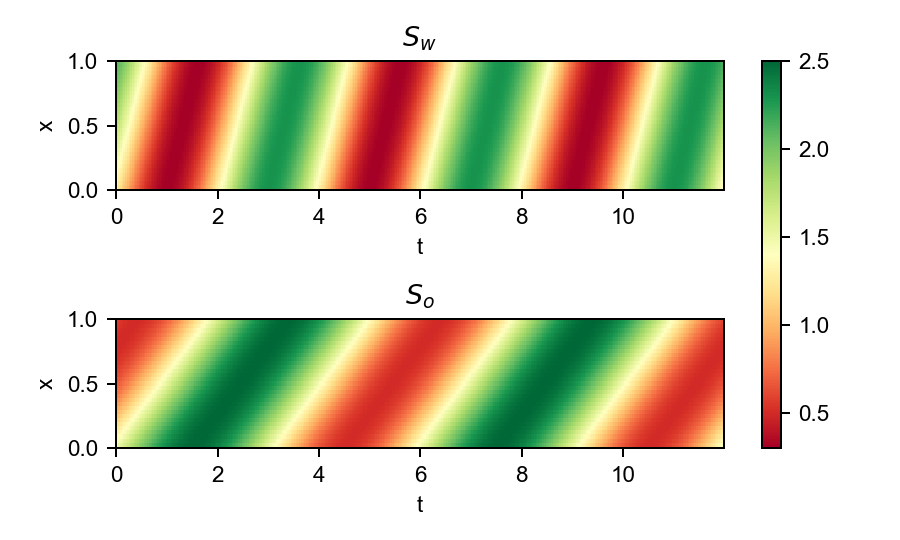

In [99]:
# Plot 2D estatico
fig1, ax1 = plt.subplots(2, 1, figsize=(5, 3), dpi=180)
norm = mpl.colors.Normalize(min(np.min(so), np.min(sw)), max(np.max(sw), np.max(so)))
c = ax1[0].pcolor(t, x, sw.T, cmap='RdYlGn', norm=norm)
ax1[1].pcolor(t, x, so.T, cmap='RdYlGn', norm=norm)

# Ajustes do plot
ax1[0].set_title('$S_w$')
ax1[1].set_title('$S_o$')

# Legenda e eixos
for i in range(2):
    ax1[i].set_ylabel('x')
    ax1[i].set_xlabel('t')
    ax1[i].set_ylim(0, 1)
fig1.tight_layout()
fig1.colorbar(c, ax=ax1)


<IPython.core.display.Javascript object>


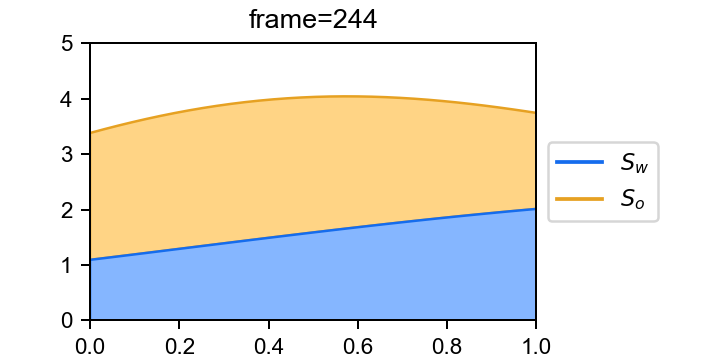

In [98]:
# Animacao
fig2, ax2 = plt.subplots(figsize=(4, 2), dpi=180)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 5)
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])

def anifunc(frame):
    global x, sw, so, tf, dt
    # Plot
    ax2.clear()
    ax2.fill_between(x, sw[frame]+so[frame], sw[frame], ec='#e6a122', fc='#ffd485')
    ax2.fill_between(x, sw[frame], ec='#156ced', fc='#85b6ff')
    
    # Ajustes do plot
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 5)
    ax2.set_title('frame='+str(frame))
    
    # Legenda
    legenda = [Line2D([0], [0], color='#156ced', label='$S_w$'),
               Line2D([0], [0], color='#e6a122', label='$S_o$')]
    ax2.legend(handles=legenda, loc='center left', bbox_to_anchor=(1, 0.5))
    return []


ani = FuncAnimation(fig2, anifunc, frames=int(tf/dt), interval=dt)
plt.show()